In [1]:
from pythonbpf import bpf, map, struct, section, bpfglobal, BPF
from pythonbpf.helper import ktime, pid
from pythonbpf.maps import HashMap, PerfEventArray
from ctypes import c_void_p, c_uint64
import matplotlib.pyplot as plt
import numpy as np

In [2]:
@bpf
@struct
class latency_event:
    pid: c_uint64
    delta_us: c_uint64  # Latency in microseconds


@bpf
@map
def start() -> HashMap:
    return HashMap(key=c_uint64, value=c_uint64, max_entries=10240)


@bpf
@map
def events() -> PerfEventArray:
    return PerfEventArray(key_size=c_uint64, value_size=c_uint64)


@bpf
@section("kprobe/vfs_read")
def do_entry(ctx: c_void_p) -> c_uint64:
    p, ts = pid(), ktime()
    start.update(p, ts)
    return 0


@bpf
@section("kretprobe/vfs_read")
def do_return(ctx: c_void_p) -> c_uint64:
    p = pid()
    tsp = start.lookup(p)

    if tsp:
        delta_ns = ktime() - tsp

        # Only track if latency > 1 microsecond
        if delta_ns > 1000:
            evt = latency_event()
            evt.pid, evt.delta_us = p, delta_ns // 1000
            events.output(evt)

        start.delete(p)

    return 0  # type: ignore [return-value]


@bpf
@bpfglobal
def LICENSE() -> str:
    return "GPL"


# Load BPF
print("Loading BPF program...")
b = BPF()
b.load()
b.attach_all()

Loading BPF program...


{'do_entry': <pylibbpf.pylibbpf.BpfProgram at 0xffff7c9e2c70>,
 'do_return': <pylibbpf.pylibbpf.BpfProgram at 0xffff7c6bb330>}

In [3]:
# Collect latencies
latencies = []


def callback(cpu, event):
    latencies.append(event.delta_us)


b["events"].open_perf_buffer(callback, struct_name="latency_event")

print("Tracing vfs_read latency... Hit Ctrl-C to end.")

try:
    while True:
        b["events"].poll(1000)
        if len(latencies) > 0 and len(latencies) % 1000 == 0:
            print(f"Collected {len(latencies)} samples...")

except KeyboardInterrupt:
    print(f"Collected {len(latencies)} samples. Generating histogram...")

Tracing vfs_read latency... Hit Ctrl-C to end.
Collected 1000 samples...
Collected 2000 samples...
Collected 3000 samples...
Collected 4000 samples...
Collected 5000 samples...
Collected 6000 samples...
Collected 6050 samples. Generating histogram...


Statistics:
  Count:  6050
  Min:    1 µs
  Max:    1086 µs
  Mean:   9.80 µs
  Median: 3.00 µs
  P95:    47.00 µs
  P99:    158.00 µs
Histogram saved to vfs_read_latency.png


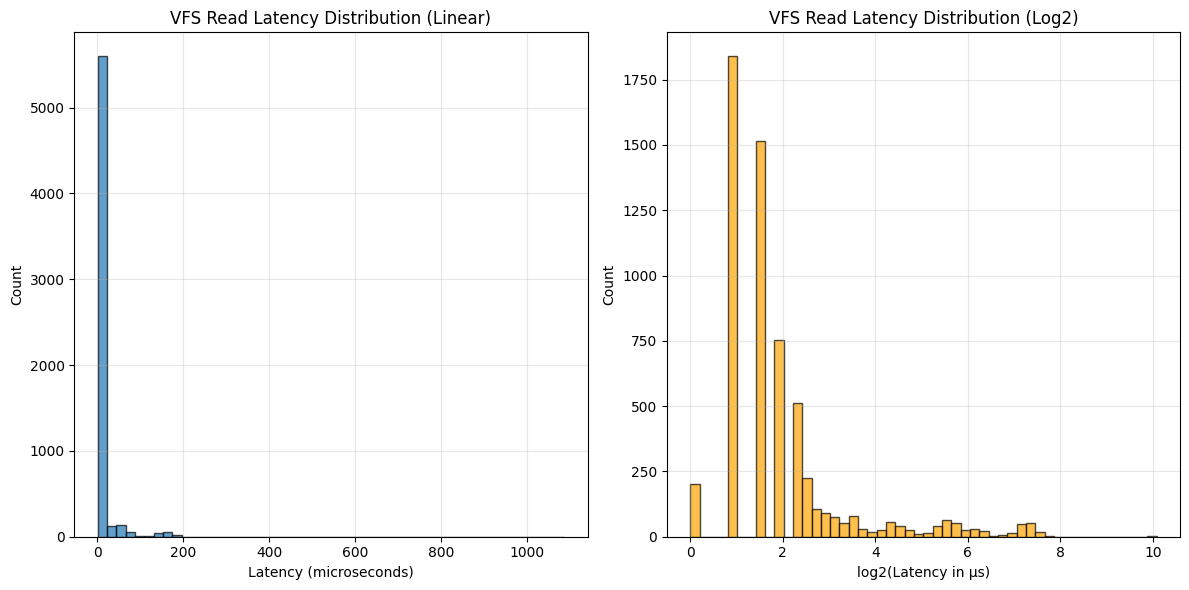

In [4]:
# Create histogram with matplotlib
if latencies:
    # Use log scale for better visualization
    log_latencies = np.log2(latencies)

    plt.figure(figsize=(12, 6))

    # Plot 1: Linear histogram
    plt.subplot(1, 2, 1)
    plt.hist(latencies, bins=50, edgecolor="black", alpha=0.7)
    plt.xlabel("Latency (microseconds)")
    plt.ylabel("Count")
    plt.title("VFS Read Latency Distribution (Linear)")
    plt.grid(True, alpha=0.3)

    # Plot 2: Log2 histogram (like BCC)
    plt.subplot(1, 2, 2)
    plt.hist(log_latencies, bins=50, edgecolor="black", alpha=0.7, color="orange")
    plt.xlabel("log2(Latency in µs)")
    plt.ylabel("Count")
    plt.title("VFS Read Latency Distribution (Log2)")
    plt.grid(True, alpha=0.3)

    # Add statistics
    print("Statistics:")
    print(f"  Count:  {len(latencies)}")
    print(f"  Min:    {min(latencies)} µs")
    print(f"  Max:    {max(latencies)} µs")
    print(f"  Mean:   {np.mean(latencies):.2f} µs")
    print(f"  Median: {np.median(latencies):.2f} µs")
    print(f"  P95:    {np.percentile(latencies, 95):.2f} µs")
    print(f"  P99:    {np.percentile(latencies, 99):.2f} µs")

    plt.tight_layout()
    plt.savefig("vfs_read_latency.png", dpi=150)
    print("Histogram saved to vfs_read_latency.png")
    plt.show()
else:
    print("No samples collected!")